## Taken from <br> https://towardsdatascience.com/how-to-build-a-diy-deep-learning-framework-in-numpy-59b5b618f9b7 <br> https://github.com/cosmic-cortex/neural-networks-from-scratch

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

## A neural network is a function <font color=blue>$f_{\theta}$</font>, takes a data  <font color=blue>$\vec{X}$</font> as input and gives the output <font color=blue>$\hat{y} = \sigma \Big( f_{\theta}(\vec{X}) \Big)$</font>. <br> <font color=blue>$f_{\theta}$</font>  has to be differentianle w.r.t <font color=blue>$\theta$</font>. <br> <font color=blue> $\sigma( ~. )$ </font> has to be differentiable as well.

In [2]:
class Function:
    """
    Abstract model of a differentiable function.
    """
    def __init__(self, *args, **kwargs):
        # initializing cache for intermediate results
        # helps with gradient calculation in some cases
        self.cache = {}
        # cache for gradients
        self.grad = {}

    def __call__(self, *args, **kwargs):
        # calculating output
        output = self.forward(*args, **kwargs)
        # calculating and caching local gradients
        self.grad = self.local_grad(*args, **kwargs)
        return output

    def forward(self, *args, **kwargs):
        """
        Forward pass of the function. Calculates the output value and the
        gradient at the input as well.
        """
        pass

    def backward(self, *args, **kwargs):
        """
        Backward pass. Computes the local gradient at the input value
        after forward pass.
        """
        pass

    def local_grad(self, *args, **kwargs):
        """
        Calculates the local gradients of the function at the given input.
        Returns:
            grad: dictionary of local gradients.
        """
        pass


## --- note the keyword 'pass'. It means "nothing happens when executed". --> A useful place holder. 
## Later when we will create a Layer or an activation function, inheriting from "Function" class, the 'pass'
## statements will be replaced by appropriate " return .."

### A neural network is built out of several layers. Each layer has its individual weight which are updated via backpropagation. 

In [3]:
class Layer(Function):
    """
    Abstract model of a neural network layer. In addition to Function, a Layer
    also has weights and gradients with respect to the weights.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.weight = {}
        self.weight_update = {}

    def _init_weights(self, *args, **kwargs):
        pass

    def _update_weights(self, lr):
        """
        Updates the weights using the corresponding _global_ gradients computed during
        backpropagation.
        Args:
             lr: float. Learning rate.
        """
        for weight_key, weight in self.weight.items():
            self.weight[weight_key] = self.weight[weight_key] - lr * self.weight_update[weight_key]

            
##-- The 'Layer' inherits from 'Function'. It adds two two new private variables (which are dictionaries),
##   'weight' and 'weight_update'. The weight_update rule has been generally defines as w --> w - lr * grad

### Our neural network will contain multiple 'Linear' layers followed by an 'Activation' layer. <br> The liner layer function <font color=blue>$f_{W,b}$</font> acts on the input data <font color=blue>$X$</font> as <font color=blue>$out = f_{W,b}(X) = WX + b$</font>

In [4]:
class Linear(Layer):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self._init_weights(in_dim, out_dim)

    def _init_weights(self, in_dim, out_dim):
        scale = 1 / np.sqrt(in_dim)
        self.weight['W'] = scale * np.random.randn(in_dim, out_dim)
        self.weight['b'] = scale * np.random.randn(1, out_dim)

    def forward(self, X):
        """
        Forward pass for the Linear layer.
        Args:
            X: numpy.ndarray of shape (n_batch, in_dim) containing
                the input value.
        Returns:
            Y: numpy.ndarray of shape of shape (n_batch, out_dim) containing
                the output value.
        """

        output = np.dot(X, self.weight['W']) + self.weight['b']

        # caching variables for backprop
        self.cache['X'] = X
        self.cache['output'] = output

        return output

    def backward(self, dY):
        """
        Backward pass for the Linear layer.
        Args:
            dY: numpy.ndarray of shape (n_batch, n_out). Global gradient
                backpropagated from the next layer.
        Returns:
            dX: numpy.ndarray of shape (n_batch, n_out). Global gradient
                of the Linear layer.
        """
        # calculating the global gradient, to be propagated backwards
        dX = dY.dot(self.grad['X'].T)
        # calculating the global gradient wrt to weights
        X = self.cache['X']
        dW = self.grad['W'].T.dot(dY)
        db = np.sum(dY, axis=0, keepdims=True)
        # caching the global gradients
        self.weight_update = {'W': dW, 'b': db}

        return dX

    def local_grad(self, X):
        """
        Local gradients of the Linear layer at X.
        Args:
            X: numpy.ndarray of shape (n_batch, in_dim) containing the
                input data.
        Returns:
            grads: dictionary of local gradients with the following items:
                X: numpy.ndarray of shape (n_batch, in_dim).
                W: numpy.ndarray of shape (n_batch, in_dim).
                b: numpy.ndarray of shape (n_batch, 1).
        """
        gradX_local = self.weight['W']
        gradW_local = X
        gradb_local = np.ones_like(self.weight['b'])
        grads = {'X': gradX_local, 'W': gradW_local, 'b': gradb_local}
        return grads

### The activation function : we choose it to be ReLU
#### The activation function doesn't have weights, just the output and gradient, hence will be inherited from 'Function'

In [5]:
def relu(x):
    return x*(x > 0)


def relu_prime(x):
    return 1*(x > 0)

# ----- ReLU ------------------- #
class ReLU(Function):
    def forward(self, X):
        return relu(X)

    def backward(self, dY):
        return dY * self.grad['X']

    def local_grad(self, X):
        grads = {'X': relu_prime(X)}
        return grads

# ------ Softmax won't be use for any gradient descent and hence we don't store the derivatives -- #
class Softmax(Function):
    def forward(self, X):
        exp_x = np.exp(X)
        probs = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return probs

    def backward(self, dY):
        pass

    def local_grad(self, X):
        pass


In [6]:
class Loss(Function):
    def forward(self, X, Y):
        """
        Computes the loss of x with respect to y.
        Args:
            X: numpy.ndarray of shape (n_batch, n_dim).
            Y: numpy.ndarray of shape (n_batch, n_dim).
        Returns:
            loss: numpy.float.
        """
        pass

    def backward(self):
        """
        Backward pass for the loss function. Since it should be the final layer
        of an architecture, no input is needed for the backward pass.
        Returns:
            gradX: numpy.ndarray of shape (n_batch, n_dim). Local gradient of the loss.
        """
        return self.grad['X']

    def local_grad(self, X, Y):
        """
        Local gradient with respect to X at (X, Y).
        Args:
            X: numpy.ndarray of shape (n_batch, n_dim).
            Y: numpy.ndarray of shape (n_batch, n_dim).
        Returns:
            gradX: numpy.ndarray of shape (n_batch, n_dim).
        """
        pass


### Crossentropy($y,\hat{y}$) = 

In [7]:
class CrossEntropyLoss(Loss):
    def forward(self, X, y):
        """
        Computes the cross entropy loss of x with respect to y.
        Args:
            X: numpy.ndarray of shape (n_batch, n_dim).
            y: numpy.ndarray of shape (n_batch, 1). Should contain class labels
                for each data point in x.
        Returns:
            crossentropy_loss: numpy.float. Cross entropy loss of x with respect to y.
        """
        # calculating crossentropy
        exp_x = np.exp(X)
        probs = exp_x/np.sum(exp_x, axis=1, keepdims=True)
        log_probs = -np.log([probs[i, y[i]] for i in range(len(probs))])
        crossentropy_loss = np.mean(log_probs)

        # caching for backprop
        self.cache['probs'] = probs
        self.cache['y'] = y

        return crossentropy_loss

    def local_grad(self, X, Y):
        probs = self.cache['probs']
        ones = np.zeros_like(probs)
        for row_idx, col_idx in enumerate(Y):
            ones[row_idx, col_idx] = 1.0

        grads = {'X': (probs - ones)/float(len(X))}
        return grads

### Define the neural net

In [8]:
class Net:
    __slots__ = ['layers', 'loss_fn']

    def __init__(self, layers, loss):
        assert isinstance(loss, Loss), 'loss must be an instance of nn.losses.Loss'
        for layer in layers:
            assert isinstance(layer, Function), 'layer should be an instance of ' \
                                                'nn.layers.Function or nn.layers.Layer'

        self.layers = layers
        self.loss_fn = loss

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def forward(self, x):
        """
        Calculates the forward pass by propagating the input through the
        layers.
        Args:
            x: numpy.ndarray. Input of the net.
        Returns:
            output: numpy.ndarray. Output of the net.
        """
        for layer in self.layers:
            x = layer(x)
        return x

    def loss(self, x, y):
        """
        Calculates the loss of the forward pass output with respect to y.
        Should be called after forward pass.
        Args:
            x: numpy.ndarray. Output of the forward pass.
            y: numpy.ndarray. Ground truth.
        Returns:
            loss: numpy.float. Loss value.
        """
        loss = self.loss_fn(x, y)
        return loss

    def backward(self):
        """
        Complete backward pass for the net. Should be called after the forward
        pass and the loss are calculated.
        Returns:
            d: numpy.ndarray of shape matching the input during forward pass.
        """
        d = self.loss_fn.backward()
        for layer in reversed(self.layers):
            d = layer.backward(d)
        return d

    def update_weights(self, lr):
        """
        Updates the weights for all layers using the corresponding gradients
        computed during backpropagation.
        Args:
             lr: float. Learning rate.
        """
        for layer in self.layers:
            if isinstance(layer, Layer):
                layer._update_weights(lr)

In [9]:
# functions for visualization
def plot_data(X1, X2, export_path=None):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        plt.scatter(X1[:, 0], X1[:, 1], c='r', edgecolor='k')
        plt.scatter(X2[:, 0], X2[:, 1], c='b', edgecolor='k')
        plt.title('The data')
        if export_path is None:
            plt.show()
        else:
            plt.savefig(export_path, dpi=500)
            
            
def make_grid(X_data, n_res=20):
    x_min, x_max = X_data[:, 0].min() - 0.5, X_data[:, 0].max() + 0.5
    y_min, y_max = X_data[:, 1].min() - 0.5, X_data[:, 1].max() + 0.5
    x_meshgrid, y_meshgrid = np.meshgrid(np.linspace(x_min, x_max, n_res),
                                         np.linspace(y_min, y_max, n_res))

    X_grid = np.concatenate((x_meshgrid.reshape(-1, 1), y_meshgrid.reshape(-1, 1)), axis=1)

    return x_meshgrid, y_meshgrid, X_grid


def plot_classifier(net, X_data, x_meshgrid, y_meshgrid, X_grid, export_path=None):
    y_grid = Softmax()(net(X_grid))[:, 0].reshape(x_meshgrid.shape)
    y_data = net(X_data)
    preds = np.argmax(y_data, axis=1)

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(5, 5))
        plt.scatter(X_data[preds == 0, 0], X_data[preds == 0, 1], c='b', zorder=1, edgecolor='k')
        plt.scatter(X_data[preds == 1, 0], X_data[preds == 1, 1], c='r', zorder=1, edgecolor='k')
        plt.contourf(x_meshgrid, y_meshgrid, y_grid, zorder=0, cmap='RdBu')
        if not export_path:
            plt.show()
        else:
            plt.savefig(export_path, dpi=500)

        plt.close('all')




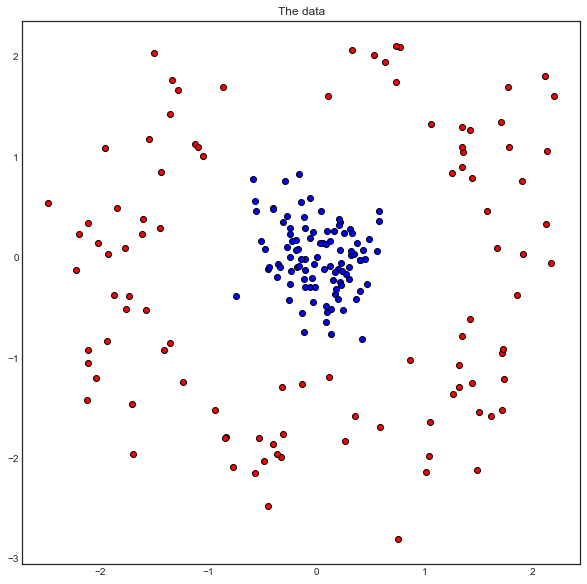

In [10]:
# generating some data
n_class_size = 100
r = 2
X1_offset = np.random.rand(n_class_size, 2) - 0.5
np.sqrt(np.sum(X1_offset**2, axis=1, keepdims=True))
X1_offset = r * X1_offset/np.sqrt(np.sum(X1_offset**2, axis=1, keepdims=True))
X1 = np.random.multivariate_normal([0, 0], [[0.1, 0], [0, 0.1]], size=n_class_size) + X1_offset
X2 = np.random.multivariate_normal([0, 0], [[0.1, 0], [0, 0.1]], size=n_class_size)

X = np.concatenate((X1, X2))
Y_labels = np.array([0]*n_class_size + [1]*n_class_size)

plot_data(X1, X2)
# make meshgrid
x_meshgrid, y_meshgrid, X_grid = make_grid(X, n_res=100)

Epoch no. 0
accuracy: 0.5350
loss: 0.6673


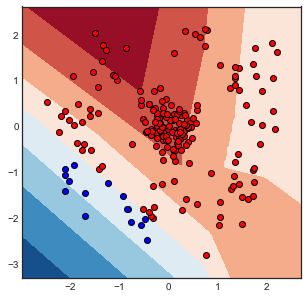

Epoch no. 1
accuracy: 0.5750
loss: 0.6379
Epoch no. 2
accuracy: 0.6300
loss: 0.6144
Epoch no. 3
accuracy: 0.6650
loss: 0.5956
Epoch no. 4
accuracy: 0.6700
loss: 0.5807
Epoch no. 5
accuracy: 0.6850
loss: 0.5686


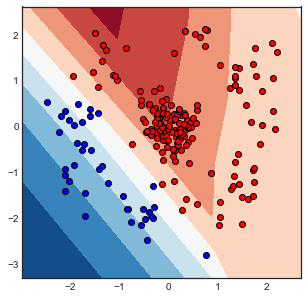

Epoch no. 6
accuracy: 0.6950
loss: 0.5589
Epoch no. 7
accuracy: 0.7050
loss: 0.5508
Epoch no. 8
accuracy: 0.7050
loss: 0.5441
Epoch no. 9
accuracy: 0.7050
loss: 0.5383
Epoch no. 10
accuracy: 0.7050
loss: 0.5334


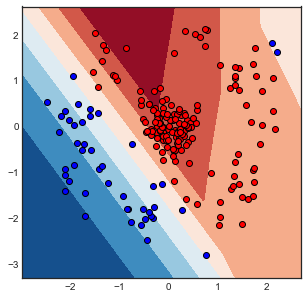

Epoch no. 11
accuracy: 0.7150
loss: 0.5292
Epoch no. 12
accuracy: 0.7200
loss: 0.5253
Epoch no. 13
accuracy: 0.7200
loss: 0.5218
Epoch no. 14
accuracy: 0.7300
loss: 0.5187
Epoch no. 15
accuracy: 0.7350
loss: 0.5157


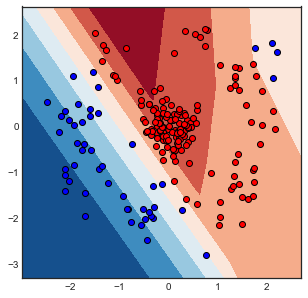

Epoch no. 16
accuracy: 0.7350
loss: 0.5129
Epoch no. 17
accuracy: 0.7400
loss: 0.5102
Epoch no. 18
accuracy: 0.7500
loss: 0.5077
Epoch no. 19
accuracy: 0.7550
loss: 0.5052
Epoch no. 20
accuracy: 0.7550
loss: 0.5027


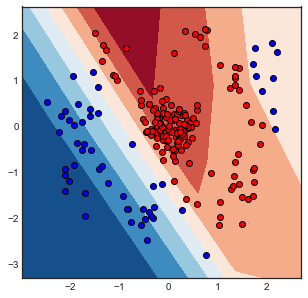

Epoch no. 21
accuracy: 0.7600
loss: 0.5004
Epoch no. 22
accuracy: 0.7600
loss: 0.4980
Epoch no. 23
accuracy: 0.7600
loss: 0.4958
Epoch no. 24
accuracy: 0.7600
loss: 0.4935
Epoch no. 25
accuracy: 0.7600
loss: 0.4913


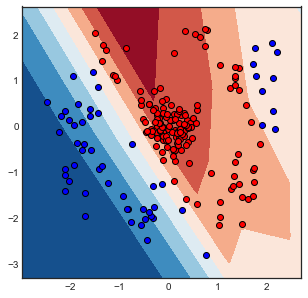

Epoch no. 26
accuracy: 0.7650
loss: 0.4891
Epoch no. 27
accuracy: 0.7650
loss: 0.4869
Epoch no. 28
accuracy: 0.7650
loss: 0.4847
Epoch no. 29
accuracy: 0.7700
loss: 0.4825
Epoch no. 30
accuracy: 0.7700
loss: 0.4803


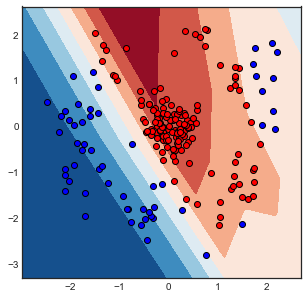

Epoch no. 31
accuracy: 0.7700
loss: 0.4781
Epoch no. 32
accuracy: 0.7750
loss: 0.4759
Epoch no. 33
accuracy: 0.7850
loss: 0.4737
Epoch no. 34
accuracy: 0.7900
loss: 0.4715
Epoch no. 35
accuracy: 0.7900
loss: 0.4692


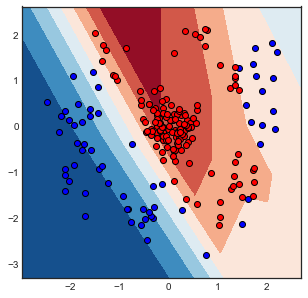

Epoch no. 36
accuracy: 0.7950
loss: 0.4670
Epoch no. 37
accuracy: 0.8050
loss: 0.4647
Epoch no. 38
accuracy: 0.8150
loss: 0.4624
Epoch no. 39
accuracy: 0.8150
loss: 0.4600
Epoch no. 40
accuracy: 0.8250
loss: 0.4576


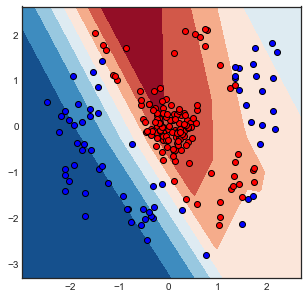

Epoch no. 41
accuracy: 0.8250
loss: 0.4552
Epoch no. 42
accuracy: 0.8250
loss: 0.4527
Epoch no. 43
accuracy: 0.8300
loss: 0.4503
Epoch no. 44
accuracy: 0.8350
loss: 0.4479
Epoch no. 45
accuracy: 0.8350
loss: 0.4454


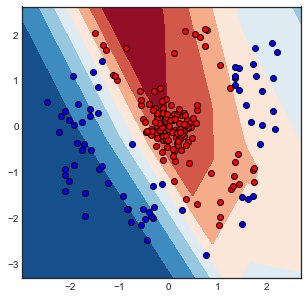

Epoch no. 46
accuracy: 0.8350
loss: 0.4429
Epoch no. 47
accuracy: 0.8350
loss: 0.4403
Epoch no. 48
accuracy: 0.8400
loss: 0.4378
Epoch no. 49
accuracy: 0.8400
loss: 0.4352
Epoch no. 50
accuracy: 0.8550
loss: 0.4326


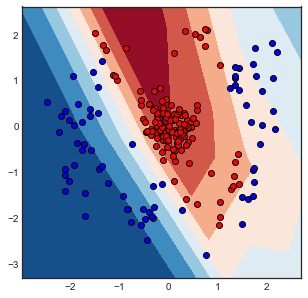

Epoch no. 51
accuracy: 0.8550
loss: 0.4299
Epoch no. 52
accuracy: 0.8600
loss: 0.4273
Epoch no. 53
accuracy: 0.8600
loss: 0.4246
Epoch no. 54
accuracy: 0.8600
loss: 0.4219
Epoch no. 55
accuracy: 0.8650
loss: 0.4191


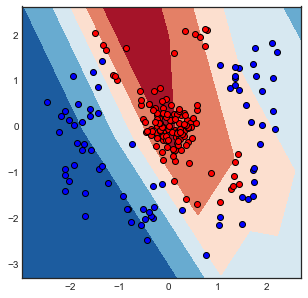

Epoch no. 56
accuracy: 0.8700
loss: 0.4164
Epoch no. 57
accuracy: 0.8700
loss: 0.4136
Epoch no. 58
accuracy: 0.8750
loss: 0.4109
Epoch no. 59
accuracy: 0.8750
loss: 0.4081
Epoch no. 60
accuracy: 0.8750
loss: 0.4052


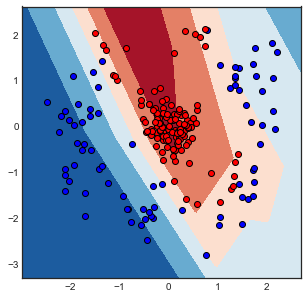

Epoch no. 61
accuracy: 0.8800
loss: 0.4024
Epoch no. 62
accuracy: 0.8800
loss: 0.3995
Epoch no. 63
accuracy: 0.8850
loss: 0.3966
Epoch no. 64
accuracy: 0.8950
loss: 0.3937
Epoch no. 65
accuracy: 0.8950
loss: 0.3907


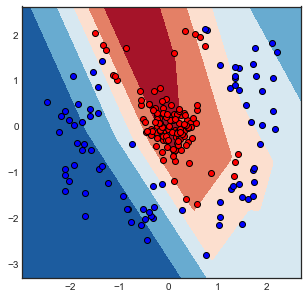

Epoch no. 66
accuracy: 0.9000
loss: 0.3877
Epoch no. 67
accuracy: 0.9000
loss: 0.3847
Epoch no. 68
accuracy: 0.9000
loss: 0.3816
Epoch no. 69
accuracy: 0.9000
loss: 0.3786
Epoch no. 70
accuracy: 0.9000
loss: 0.3755


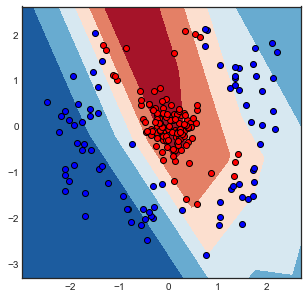

Epoch no. 71
accuracy: 0.9100
loss: 0.3724
Epoch no. 72
accuracy: 0.9150
loss: 0.3693
Epoch no. 73
accuracy: 0.9150
loss: 0.3662
Epoch no. 74
accuracy: 0.9250
loss: 0.3630
Epoch no. 75
accuracy: 0.9250
loss: 0.3599


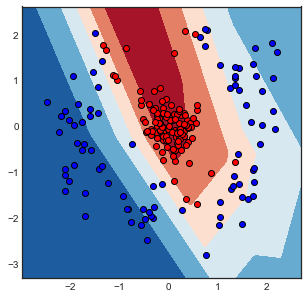

Epoch no. 76
accuracy: 0.9250
loss: 0.3568
Epoch no. 77
accuracy: 0.9300
loss: 0.3537
Epoch no. 78
accuracy: 0.9300
loss: 0.3505
Epoch no. 79
accuracy: 0.9350
loss: 0.3473
Epoch no. 80
accuracy: 0.9350
loss: 0.3441


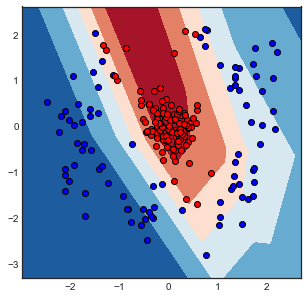

Epoch no. 81
accuracy: 0.9350
loss: 0.3409
Epoch no. 82
accuracy: 0.9400
loss: 0.3377
Epoch no. 83
accuracy: 0.9400
loss: 0.3344
Epoch no. 84
accuracy: 0.9400
loss: 0.3312
Epoch no. 85
accuracy: 0.9400
loss: 0.3279


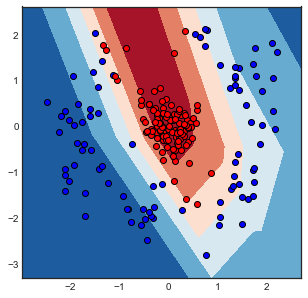

Epoch no. 86
accuracy: 0.9400
loss: 0.3246
Epoch no. 87
accuracy: 0.9400
loss: 0.3213
Epoch no. 88
accuracy: 0.9450
loss: 0.3180
Epoch no. 89
accuracy: 0.9450
loss: 0.3147
Epoch no. 90
accuracy: 0.9450
loss: 0.3115


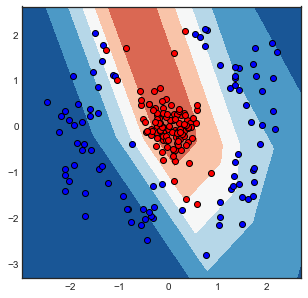

Epoch no. 91
accuracy: 0.9500
loss: 0.3082
Epoch no. 92
accuracy: 0.9550
loss: 0.3050
Epoch no. 93
accuracy: 0.9550
loss: 0.3018
Epoch no. 94
accuracy: 0.9600
loss: 0.2985
Epoch no. 95
accuracy: 0.9600
loss: 0.2954


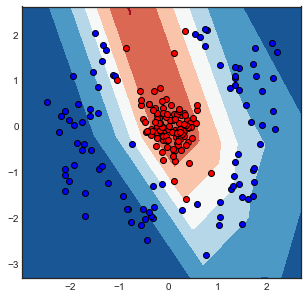

Epoch no. 96
accuracy: 0.9600
loss: 0.2923
Epoch no. 97
accuracy: 0.9650
loss: 0.2892
Epoch no. 98
accuracy: 0.9650
loss: 0.2861
Epoch no. 99
accuracy: 0.9650
loss: 0.2831
Epoch no. 100
accuracy: 0.9650
loss: 0.2801


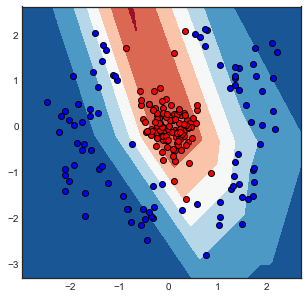

Epoch no. 101
accuracy: 0.9650
loss: 0.2771
Epoch no. 102
accuracy: 0.9650
loss: 0.2742
Epoch no. 103
accuracy: 0.9650
loss: 0.2713
Epoch no. 104
accuracy: 0.9650
loss: 0.2684
Epoch no. 105
accuracy: 0.9700
loss: 0.2656


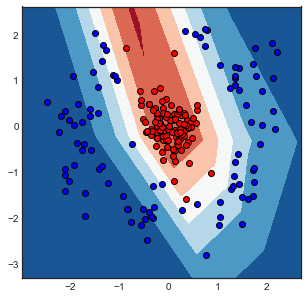

Epoch no. 106
accuracy: 0.9700
loss: 0.2628
Epoch no. 107
accuracy: 0.9700
loss: 0.2601
Epoch no. 108
accuracy: 0.9700
loss: 0.2574
Epoch no. 109
accuracy: 0.9700
loss: 0.2547
Epoch no. 110
accuracy: 0.9700
loss: 0.2521


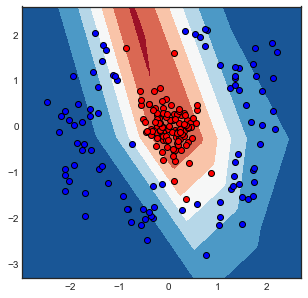

Epoch no. 111
accuracy: 0.9700
loss: 0.2495
Epoch no. 112
accuracy: 0.9700
loss: 0.2469
Epoch no. 113
accuracy: 0.9700
loss: 0.2444
Epoch no. 114
accuracy: 0.9700
loss: 0.2419
Epoch no. 115
accuracy: 0.9700
loss: 0.2395


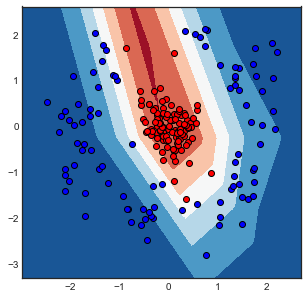

Epoch no. 116
accuracy: 0.9700
loss: 0.2371
Epoch no. 117
accuracy: 0.9700
loss: 0.2347
Epoch no. 118
accuracy: 0.9700
loss: 0.2324
Epoch no. 119
accuracy: 0.9750
loss: 0.2301
Epoch no. 120
accuracy: 0.9750
loss: 0.2278


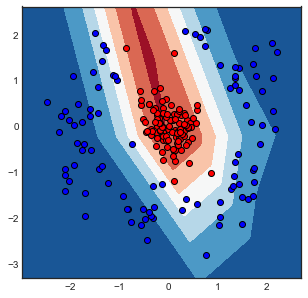

Epoch no. 121
accuracy: 0.9750
loss: 0.2256
Epoch no. 122
accuracy: 0.9750
loss: 0.2235
Epoch no. 123
accuracy: 0.9750
loss: 0.2213
Epoch no. 124
accuracy: 0.9750
loss: 0.2191
Epoch no. 125
accuracy: 0.9750
loss: 0.2170


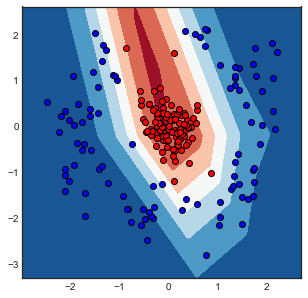

Epoch no. 126
accuracy: 0.9750
loss: 0.2149
Epoch no. 127
accuracy: 0.9750
loss: 0.2129
Epoch no. 128
accuracy: 0.9750
loss: 0.2109
Epoch no. 129
accuracy: 0.9750
loss: 0.2089
Epoch no. 130
accuracy: 0.9750
loss: 0.2069


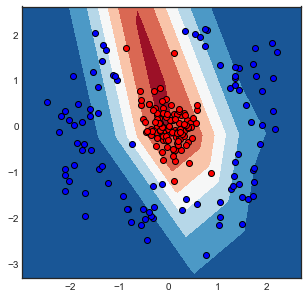

Epoch no. 131
accuracy: 0.9750
loss: 0.2049
Epoch no. 132
accuracy: 0.9750
loss: 0.2030
Epoch no. 133
accuracy: 0.9750
loss: 0.2011
Epoch no. 134
accuracy: 0.9800
loss: 0.1992
Epoch no. 135
accuracy: 0.9800
loss: 0.1974


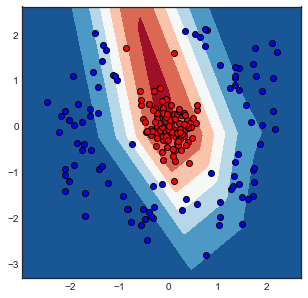

Epoch no. 136
accuracy: 0.9800
loss: 0.1956
Epoch no. 137
accuracy: 0.9800
loss: 0.1938
Epoch no. 138
accuracy: 0.9800
loss: 0.1920
Epoch no. 139
accuracy: 0.9800
loss: 0.1903
Epoch no. 140
accuracy: 0.9800
loss: 0.1886


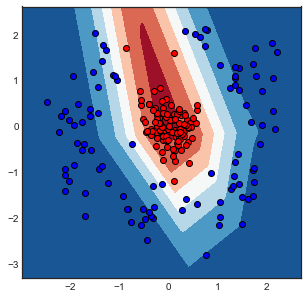

Epoch no. 141
accuracy: 0.9800
loss: 0.1869
Epoch no. 142
accuracy: 0.9800
loss: 0.1853
Epoch no. 143
accuracy: 0.9800
loss: 0.1836
Epoch no. 144
accuracy: 0.9800
loss: 0.1820
Epoch no. 145
accuracy: 0.9800
loss: 0.1805


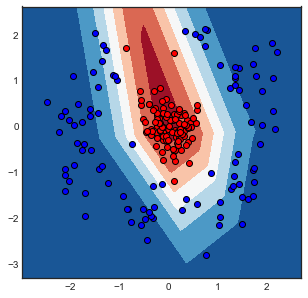

Epoch no. 146
accuracy: 0.9800
loss: 0.1789
Epoch no. 147
accuracy: 0.9800
loss: 0.1774
Epoch no. 148
accuracy: 0.9800
loss: 0.1759
Epoch no. 149
accuracy: 0.9800
loss: 0.1745
Epoch no. 150
accuracy: 0.9800
loss: 0.1730


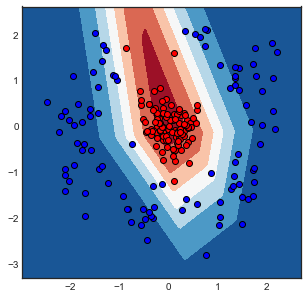

Epoch no. 151
accuracy: 0.9800
loss: 0.1716
Epoch no. 152
accuracy: 0.9800
loss: 0.1702
Epoch no. 153
accuracy: 0.9800
loss: 0.1688
Epoch no. 154
accuracy: 0.9800
loss: 0.1675
Epoch no. 155
accuracy: 0.9800
loss: 0.1661


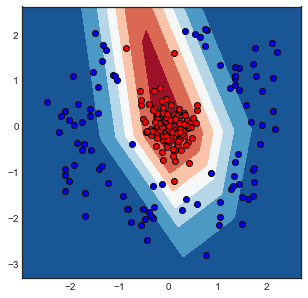

Epoch no. 156
accuracy: 0.9800
loss: 0.1648
Epoch no. 157
accuracy: 0.9800
loss: 0.1635
Epoch no. 158
accuracy: 0.9800
loss: 0.1622
Epoch no. 159
accuracy: 0.9800
loss: 0.1610
Epoch no. 160
accuracy: 0.9800
loss: 0.1597


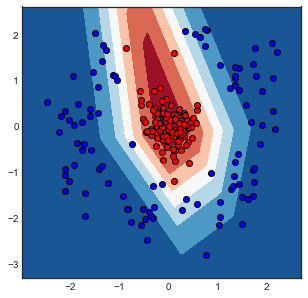

Epoch no. 161
accuracy: 0.9800
loss: 0.1585
Epoch no. 162
accuracy: 0.9800
loss: 0.1573
Epoch no. 163
accuracy: 0.9800
loss: 0.1561
Epoch no. 164
accuracy: 0.9800
loss: 0.1549
Epoch no. 165
accuracy: 0.9800
loss: 0.1537


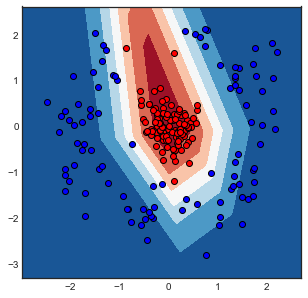

Epoch no. 166
accuracy: 0.9800
loss: 0.1525
Epoch no. 167
accuracy: 0.9800
loss: 0.1514
Epoch no. 168
accuracy: 0.9800
loss: 0.1503
Epoch no. 169
accuracy: 0.9800
loss: 0.1492
Epoch no. 170
accuracy: 0.9800
loss: 0.1481


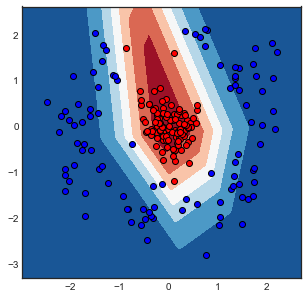

Epoch no. 171
accuracy: 0.9800
loss: 0.1470
Epoch no. 172
accuracy: 0.9800
loss: 0.1459
Epoch no. 173
accuracy: 0.9800
loss: 0.1449
Epoch no. 174
accuracy: 0.9800
loss: 0.1438
Epoch no. 175
accuracy: 0.9800
loss: 0.1428


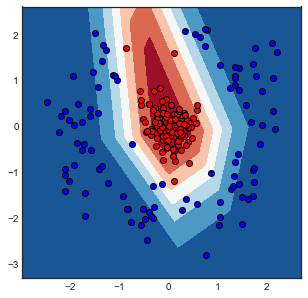

Epoch no. 176
accuracy: 0.9800
loss: 0.1418
Epoch no. 177
accuracy: 0.9800
loss: 0.1408
Epoch no. 178
accuracy: 0.9800
loss: 0.1398
Epoch no. 179
accuracy: 0.9800
loss: 0.1388
Epoch no. 180
accuracy: 0.9800
loss: 0.1379


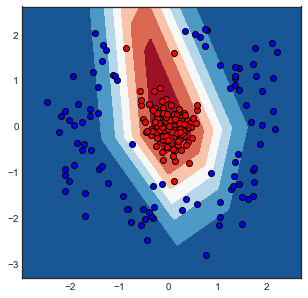

Epoch no. 181
accuracy: 0.9800
loss: 0.1369
Epoch no. 182
accuracy: 0.9800
loss: 0.1360
Epoch no. 183
accuracy: 0.9800
loss: 0.1351
Epoch no. 184
accuracy: 0.9800
loss: 0.1342
Epoch no. 185
accuracy: 0.9800
loss: 0.1333


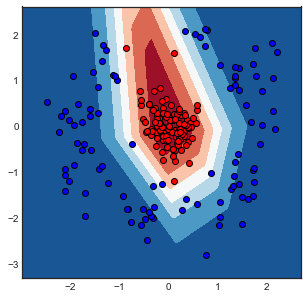

Epoch no. 186
accuracy: 0.9800
loss: 0.1324
Epoch no. 187
accuracy: 0.9800
loss: 0.1315
Epoch no. 188
accuracy: 0.9800
loss: 0.1306
Epoch no. 189
accuracy: 0.9800
loss: 0.1298
Epoch no. 190
accuracy: 0.9800
loss: 0.1289


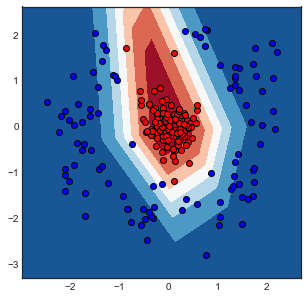

Epoch no. 191
accuracy: 0.9800
loss: 0.1281
Epoch no. 192
accuracy: 0.9800
loss: 0.1273
Epoch no. 193
accuracy: 0.9800
loss: 0.1264
Epoch no. 194
accuracy: 0.9800
loss: 0.1256
Epoch no. 195
accuracy: 0.9800
loss: 0.1248


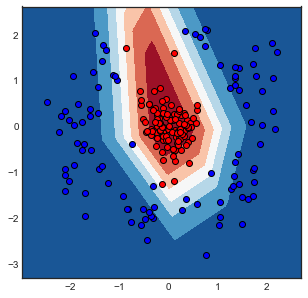

Epoch no. 196
accuracy: 0.9750
loss: 0.1240
Epoch no. 197
accuracy: 0.9750
loss: 0.1233
Epoch no. 198
accuracy: 0.9750
loss: 0.1225
Epoch no. 199
accuracy: 0.9750
loss: 0.1217
Epoch no. 200
accuracy: 0.9750
loss: 0.1210


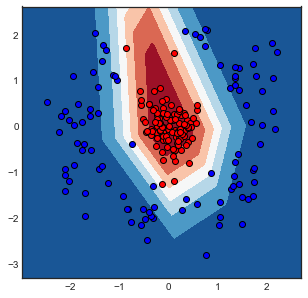

Epoch no. 201
accuracy: 0.9750
loss: 0.1202
Epoch no. 202
accuracy: 0.9750
loss: 0.1195
Epoch no. 203
accuracy: 0.9750
loss: 0.1188
Epoch no. 204
accuracy: 0.9750
loss: 0.1180
Epoch no. 205
accuracy: 0.9750
loss: 0.1173


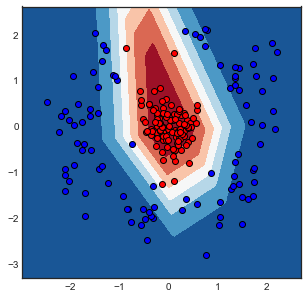

Epoch no. 206
accuracy: 0.9750
loss: 0.1166
Epoch no. 207
accuracy: 0.9750
loss: 0.1159
Epoch no. 208
accuracy: 0.9750
loss: 0.1152
Epoch no. 209
accuracy: 0.9750
loss: 0.1146
Epoch no. 210
accuracy: 0.9750
loss: 0.1139


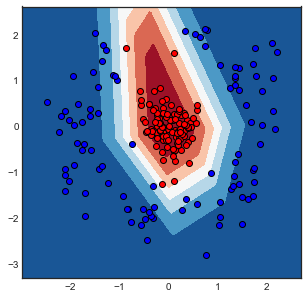

Epoch no. 211
accuracy: 0.9750
loss: 0.1132
Epoch no. 212
accuracy: 0.9750
loss: 0.1126
Epoch no. 213
accuracy: 0.9750
loss: 0.1119
Epoch no. 214
accuracy: 0.9750
loss: 0.1113
Epoch no. 215
accuracy: 0.9750
loss: 0.1106


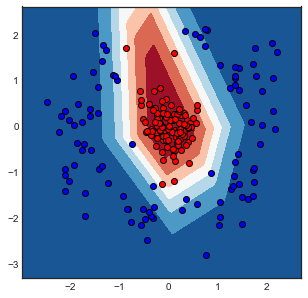

Epoch no. 216
accuracy: 0.9750
loss: 0.1100
Epoch no. 217
accuracy: 0.9750
loss: 0.1094
Epoch no. 218
accuracy: 0.9800
loss: 0.1087
Epoch no. 219
accuracy: 0.9800
loss: 0.1081
Epoch no. 220
accuracy: 0.9800
loss: 0.1075


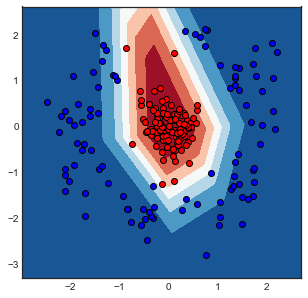

Epoch no. 221
accuracy: 0.9800
loss: 0.1069
Epoch no. 222
accuracy: 0.9800
loss: 0.1063
Epoch no. 223
accuracy: 0.9800
loss: 0.1057
Epoch no. 224
accuracy: 0.9800
loss: 0.1052
Epoch no. 225
accuracy: 0.9800
loss: 0.1046


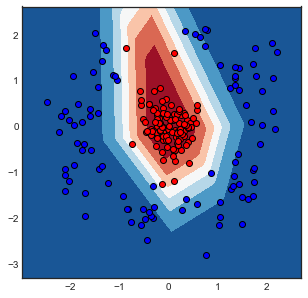

Epoch no. 226
accuracy: 0.9800
loss: 0.1040
Epoch no. 227
accuracy: 0.9800
loss: 0.1034
Epoch no. 228
accuracy: 0.9800
loss: 0.1029
Epoch no. 229
accuracy: 0.9800
loss: 0.1023
Epoch no. 230
accuracy: 0.9800
loss: 0.1018


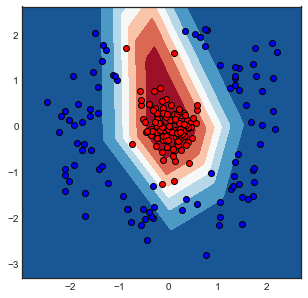

Epoch no. 231
accuracy: 0.9800
loss: 0.1012
Epoch no. 232
accuracy: 0.9800
loss: 0.1007
Epoch no. 233
accuracy: 0.9800
loss: 0.1002
Epoch no. 234
accuracy: 0.9800
loss: 0.0997
Epoch no. 235
accuracy: 0.9800
loss: 0.0991


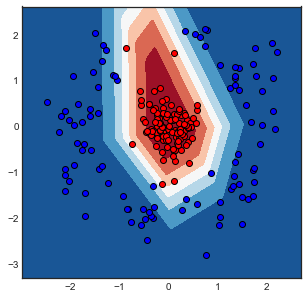

Epoch no. 236
accuracy: 0.9800
loss: 0.0986
Epoch no. 237
accuracy: 0.9800
loss: 0.0981
Epoch no. 238
accuracy: 0.9800
loss: 0.0976
Epoch no. 239
accuracy: 0.9800
loss: 0.0971
Epoch no. 240
accuracy: 0.9800
loss: 0.0966


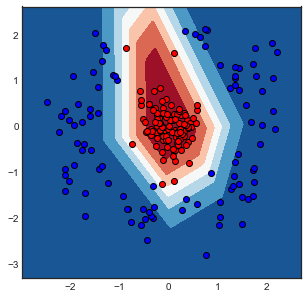

Epoch no. 241
accuracy: 0.9800
loss: 0.0961
Epoch no. 242
accuracy: 0.9800
loss: 0.0956
Epoch no. 243
accuracy: 0.9800
loss: 0.0951
Epoch no. 244
accuracy: 0.9800
loss: 0.0947
Epoch no. 245
accuracy: 0.9800
loss: 0.0942


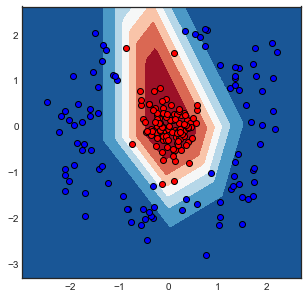

Epoch no. 246
accuracy: 0.9800
loss: 0.0937
Epoch no. 247
accuracy: 0.9850
loss: 0.0933
Epoch no. 248
accuracy: 0.9850
loss: 0.0928
Epoch no. 249
accuracy: 0.9850
loss: 0.0923
Epoch no. 250
accuracy: 0.9850
loss: 0.0919


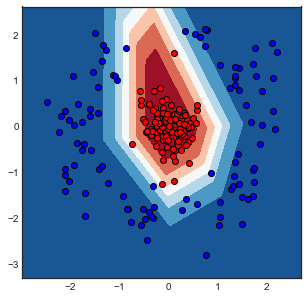

Epoch no. 251
accuracy: 0.9850
loss: 0.0914
Epoch no. 252
accuracy: 0.9850
loss: 0.0910
Epoch no. 253
accuracy: 0.9850
loss: 0.0906
Epoch no. 254
accuracy: 0.9850
loss: 0.0901
Epoch no. 255
accuracy: 0.9850
loss: 0.0897


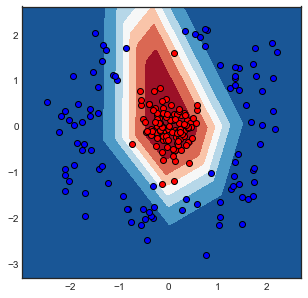

Epoch no. 256
accuracy: 0.9850
loss: 0.0893
Epoch no. 257
accuracy: 0.9850
loss: 0.0888
Epoch no. 258
accuracy: 0.9850
loss: 0.0884
Epoch no. 259
accuracy: 0.9850
loss: 0.0880
Epoch no. 260
accuracy: 0.9850
loss: 0.0876


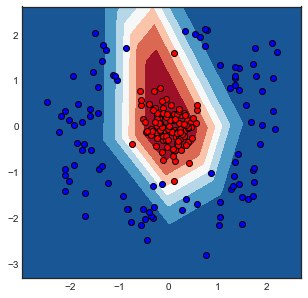

Epoch no. 261
accuracy: 0.9900
loss: 0.0872
Epoch no. 262
accuracy: 0.9900
loss: 0.0868
Epoch no. 263
accuracy: 0.9900
loss: 0.0864
Epoch no. 264
accuracy: 0.9900
loss: 0.0860
Epoch no. 265
accuracy: 0.9900
loss: 0.0856


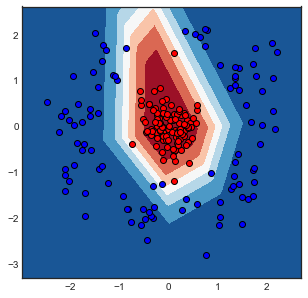

Epoch no. 266
accuracy: 0.9900
loss: 0.0852
Epoch no. 267
accuracy: 0.9900
loss: 0.0848
Epoch no. 268
accuracy: 0.9900
loss: 0.0844
Epoch no. 269
accuracy: 0.9900
loss: 0.0841
Epoch no. 270
accuracy: 0.9900
loss: 0.0837


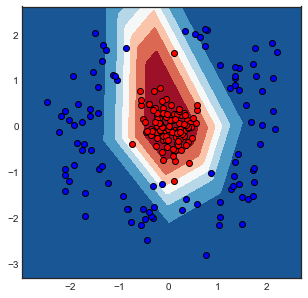

Epoch no. 271
accuracy: 0.9900
loss: 0.0833
Epoch no. 272
accuracy: 0.9900
loss: 0.0829
Epoch no. 273
accuracy: 0.9900
loss: 0.0826
Epoch no. 274
accuracy: 0.9900
loss: 0.0822
Epoch no. 275
accuracy: 0.9900
loss: 0.0818


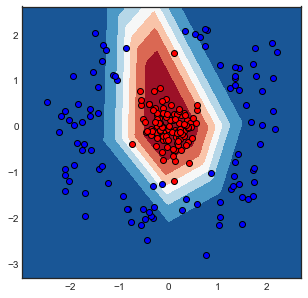

Epoch no. 276
accuracy: 0.9900
loss: 0.0815
Epoch no. 277
accuracy: 0.9900
loss: 0.0811
Epoch no. 278
accuracy: 0.9900
loss: 0.0808
Epoch no. 279
accuracy: 0.9900
loss: 0.0804
Epoch no. 280
accuracy: 0.9900
loss: 0.0801


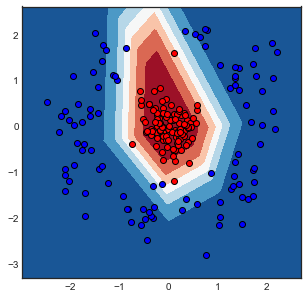

Epoch no. 281
accuracy: 0.9900
loss: 0.0797
Epoch no. 282
accuracy: 0.9900
loss: 0.0794
Epoch no. 283
accuracy: 0.9900
loss: 0.0791
Epoch no. 284
accuracy: 0.9900
loss: 0.0787
Epoch no. 285
accuracy: 0.9900
loss: 0.0784


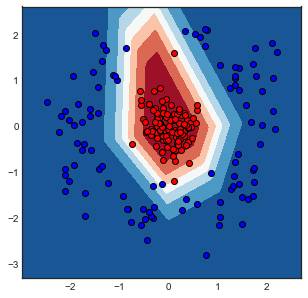

Epoch no. 286
accuracy: 0.9900
loss: 0.0781
Epoch no. 287
accuracy: 0.9900
loss: 0.0777
Epoch no. 288
accuracy: 0.9900
loss: 0.0774
Epoch no. 289
accuracy: 0.9900
loss: 0.0771
Epoch no. 290
accuracy: 0.9900
loss: 0.0768


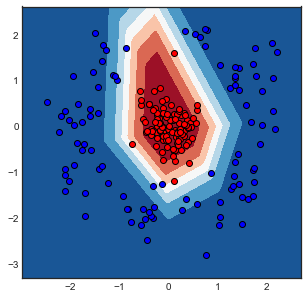

Epoch no. 291
accuracy: 0.9900
loss: 0.0765
Epoch no. 292
accuracy: 0.9900
loss: 0.0761
Epoch no. 293
accuracy: 0.9900
loss: 0.0758
Epoch no. 294
accuracy: 0.9900
loss: 0.0755
Epoch no. 295
accuracy: 0.9900
loss: 0.0752


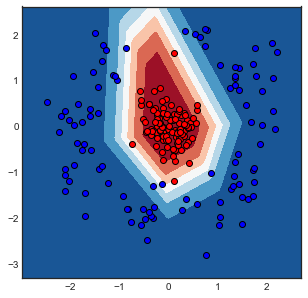

Epoch no. 296
accuracy: 0.9900
loss: 0.0749
Epoch no. 297
accuracy: 0.9900
loss: 0.0746
Epoch no. 298
accuracy: 0.9900
loss: 0.0743
Epoch no. 299
accuracy: 0.9900
loss: 0.0740


In [11]:



net = Net(layers=[Linear(2, 4), ReLU(), Linear(4, 2)],
          loss=CrossEntropyLoss())

n_epochs = 300

loss_val, acc_val = [], []

for epoch_idx in range(n_epochs):
    print("Epoch no. %d" % epoch_idx)
    out = net(X)
    # prediction accuracy
    pred = np.argmax(out, axis=1)
    print("accuracy: %1.4f" % (1 - np.abs(pred - Y_labels).sum()/200))
    loss = net.loss(out, Y_labels)
    print('loss: %1.4f' % loss)
    grad = net.backward()
    net.update_weights(lr=0.1)
    
    acc = 1 - np.abs(pred - Y_labels).sum()/200
    loss_val.append(loss)
    acc_val.append(acc)
    
    if epoch_idx % 5 == 0:
        plot_classifier(net, X, x_meshgrid, y_meshgrid, X_grid)

In [12]:
##plt.plot??

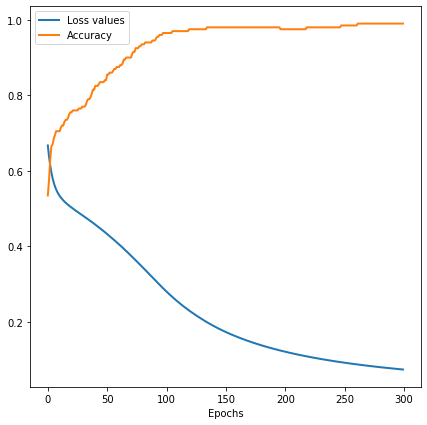

In [13]:
plt.figure(figsize=(7, 7))
plt.plot( np.arange(0, n_epochs, 1) ,  np.array(loss_val), linewidth=2, label='Loss values' )
plt.plot( np.arange(0, n_epochs, 1) ,  np.array(acc_val), linewidth=2, label='Accuracy' )
plt.xlabel('Epochs')
plt.legend()

In [14]:
x_meshgrid.shape

(100, 100)

In [15]:
X.shape, Y_labels.shape

((200, 2), (200,))

In [16]:
net.layers[0]

### Generating a new random data point and see prediction on that

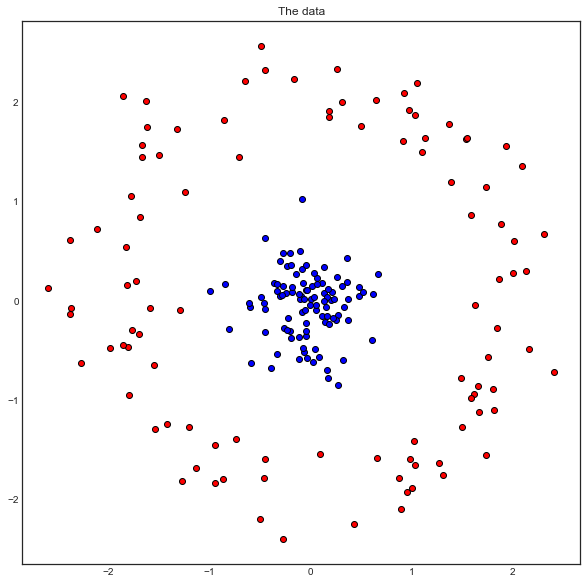

In [17]:
# generating some data
n_class_size = 100
r = 2
X1_offset = np.random.rand(n_class_size, 2) - 0.5
np.sqrt(np.sum(X1_offset**2, axis=1, keepdims=True))
X1_offset = r * X1_offset/np.sqrt(np.sum(X1_offset**2, axis=1, keepdims=True))
X1 = np.random.multivariate_normal([0, 0], [[0.1, 0], [0, 0.1]], size=n_class_size) + X1_offset
X2 = np.random.multivariate_normal([0, 0], [[0.1, 0], [0, 0.1]], size=n_class_size)

X_test = np.concatenate((X1, X2))
Y_labels_test = np.array([0]*n_class_size + [1]*n_class_size)

plot_data(X1, X2)
# make meshgrid
x_meshgrid, y_meshgrid, X_grid = make_grid(X_test, n_res=100)

In [18]:
out = net(X_test)
pred = np.argmax(out, axis=1)

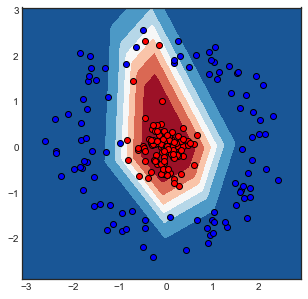

accuracy: 0.9800


In [19]:
plot_classifier(net, X_test, x_meshgrid, y_meshgrid, X_grid)
print("accuracy: %1.4f" % (1 - np.abs(pred - Y_labels_test).sum()/200))

### Lets try a deeper network

Epoch no. 0
accuracy: 0.6200
loss: 0.7351


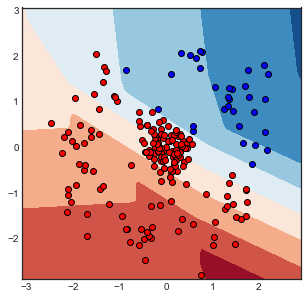

Epoch no. 1
accuracy: 0.6300
loss: 0.7270
Epoch no. 2
accuracy: 0.6300
loss: 0.7199
Epoch no. 3
accuracy: 0.6300
loss: 0.7135
Epoch no. 4
accuracy: 0.6350
loss: 0.7076
Epoch no. 5
accuracy: 0.6400
loss: 0.7024


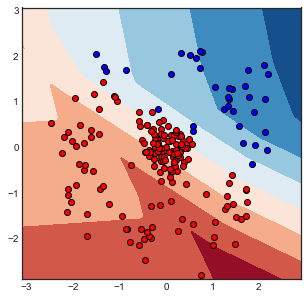

Epoch no. 6
accuracy: 0.6450
loss: 0.6977
Epoch no. 7
accuracy: 0.6450
loss: 0.6934
Epoch no. 8
accuracy: 0.6450
loss: 0.6896
Epoch no. 9
accuracy: 0.6450
loss: 0.6860
Epoch no. 10
accuracy: 0.6450
loss: 0.6826


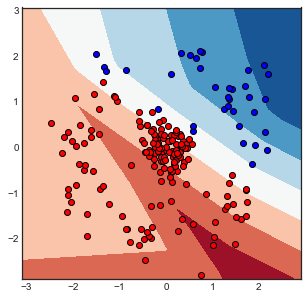

Epoch no. 11
accuracy: 0.6450
loss: 0.6795
Epoch no. 12
accuracy: 0.6450
loss: 0.6765
Epoch no. 13
accuracy: 0.6450
loss: 0.6736
Epoch no. 14
accuracy: 0.6450
loss: 0.6705
Epoch no. 15
accuracy: 0.6450
loss: 0.6677


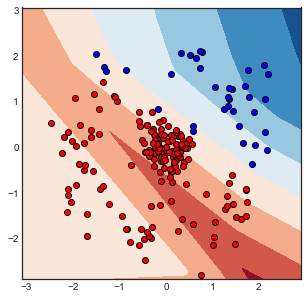

Epoch no. 16
accuracy: 0.6450
loss: 0.6648
Epoch no. 17
accuracy: 0.6450
loss: 0.6620
Epoch no. 18
accuracy: 0.7000
loss: 0.6592
Epoch no. 19
accuracy: 0.7800
loss: 0.6563
Epoch no. 20
accuracy: 0.7950
loss: 0.6534


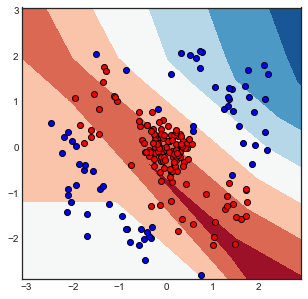

Epoch no. 21
accuracy: 0.8050
loss: 0.6505
Epoch no. 22
accuracy: 0.8150
loss: 0.6476
Epoch no. 23
accuracy: 0.8150
loss: 0.6447
Epoch no. 24
accuracy: 0.8300
loss: 0.6418
Epoch no. 25
accuracy: 0.8450
loss: 0.6390


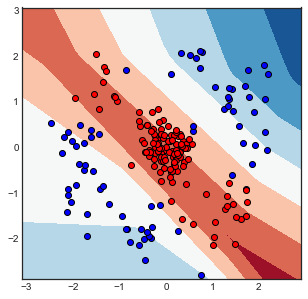

Epoch no. 26
accuracy: 0.8500
loss: 0.6361
Epoch no. 27
accuracy: 0.8550
loss: 0.6331
Epoch no. 28
accuracy: 0.8500
loss: 0.6302
Epoch no. 29
accuracy: 0.8650
loss: 0.6274
Epoch no. 30
accuracy: 0.8650
loss: 0.6245


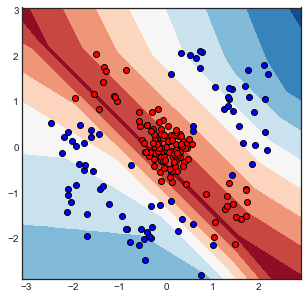

Epoch no. 31
accuracy: 0.8600
loss: 0.6217
Epoch no. 32
accuracy: 0.8600
loss: 0.6190
Epoch no. 33
accuracy: 0.8550
loss: 0.6163
Epoch no. 34
accuracy: 0.8550
loss: 0.6138
Epoch no. 35
accuracy: 0.8550
loss: 0.6113


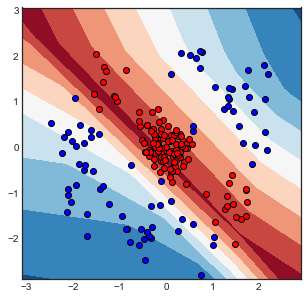

Epoch no. 36
accuracy: 0.8550
loss: 0.6090
Epoch no. 37
accuracy: 0.8600
loss: 0.6066
Epoch no. 38
accuracy: 0.8600
loss: 0.6042
Epoch no. 39
accuracy: 0.8600
loss: 0.6018
Epoch no. 40
accuracy: 0.8600
loss: 0.5994


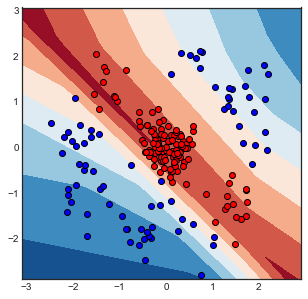

Epoch no. 41
accuracy: 0.8650
loss: 0.5971
Epoch no. 42
accuracy: 0.8650
loss: 0.5947
Epoch no. 43
accuracy: 0.8650
loss: 0.5924
Epoch no. 44
accuracy: 0.8600
loss: 0.5900
Epoch no. 45
accuracy: 0.8600
loss: 0.5876


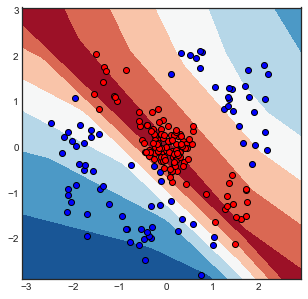

Epoch no. 46
accuracy: 0.8550
loss: 0.5852
Epoch no. 47
accuracy: 0.8550
loss: 0.5828
Epoch no. 48
accuracy: 0.8600
loss: 0.5805
Epoch no. 49
accuracy: 0.8550
loss: 0.5780
Epoch no. 50
accuracy: 0.8550
loss: 0.5756


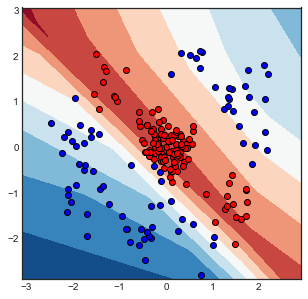

Epoch no. 51
accuracy: 0.8550
loss: 0.5731
Epoch no. 52
accuracy: 0.8550
loss: 0.5707
Epoch no. 53
accuracy: 0.8550
loss: 0.5682
Epoch no. 54
accuracy: 0.8550
loss: 0.5657
Epoch no. 55
accuracy: 0.8550
loss: 0.5631


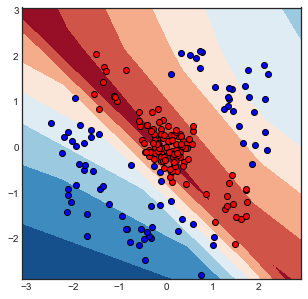

Epoch no. 56
accuracy: 0.8550
loss: 0.5605
Epoch no. 57
accuracy: 0.8550
loss: 0.5580
Epoch no. 58
accuracy: 0.8550
loss: 0.5553
Epoch no. 59
accuracy: 0.8550
loss: 0.5527
Epoch no. 60
accuracy: 0.8550
loss: 0.5501


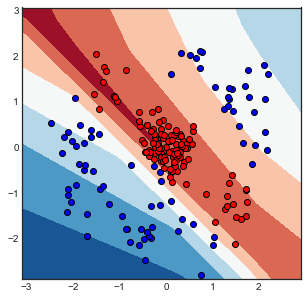

Epoch no. 61
accuracy: 0.8550
loss: 0.5475
Epoch no. 62
accuracy: 0.8550
loss: 0.5448
Epoch no. 63
accuracy: 0.8550
loss: 0.5422
Epoch no. 64
accuracy: 0.8550
loss: 0.5395
Epoch no. 65
accuracy: 0.8550
loss: 0.5368


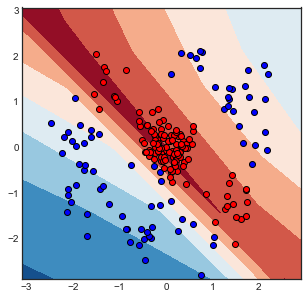

Epoch no. 66
accuracy: 0.8550
loss: 0.5341
Epoch no. 67
accuracy: 0.8550
loss: 0.5314
Epoch no. 68
accuracy: 0.8550
loss: 0.5287
Epoch no. 69
accuracy: 0.8550
loss: 0.5259
Epoch no. 70
accuracy: 0.8600
loss: 0.5232


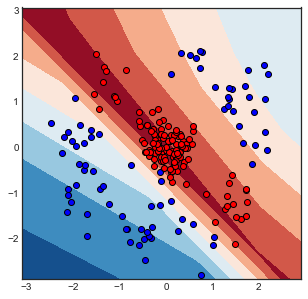

Epoch no. 71
accuracy: 0.8600
loss: 0.5205
Epoch no. 72
accuracy: 0.8650
loss: 0.5178
Epoch no. 73
accuracy: 0.8650
loss: 0.5150
Epoch no. 74
accuracy: 0.8650
loss: 0.5123
Epoch no. 75
accuracy: 0.8650
loss: 0.5095


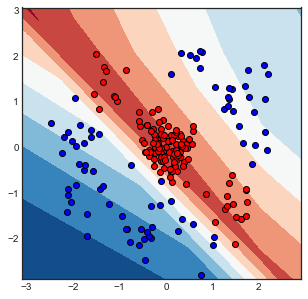

Epoch no. 76
accuracy: 0.8650
loss: 0.5067
Epoch no. 77
accuracy: 0.8650
loss: 0.5039
Epoch no. 78
accuracy: 0.8650
loss: 0.5011
Epoch no. 79
accuracy: 0.8650
loss: 0.4983
Epoch no. 80
accuracy: 0.8650
loss: 0.4955


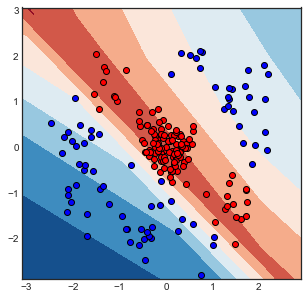

Epoch no. 81
accuracy: 0.8650
loss: 0.4926
Epoch no. 82
accuracy: 0.8650
loss: 0.4898
Epoch no. 83
accuracy: 0.8650
loss: 0.4870
Epoch no. 84
accuracy: 0.8650
loss: 0.4842
Epoch no. 85
accuracy: 0.8650
loss: 0.4813


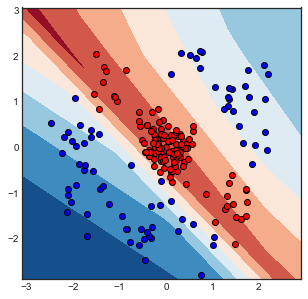

Epoch no. 86
accuracy: 0.8650
loss: 0.4785
Epoch no. 87
accuracy: 0.8650
loss: 0.4757
Epoch no. 88
accuracy: 0.8650
loss: 0.4729
Epoch no. 89
accuracy: 0.8650
loss: 0.4702
Epoch no. 90
accuracy: 0.8650
loss: 0.4674


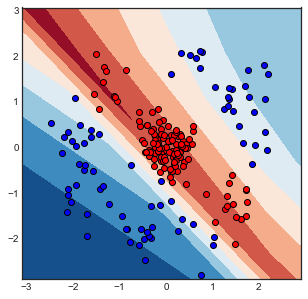

Epoch no. 91
accuracy: 0.8650
loss: 0.4647
Epoch no. 92
accuracy: 0.8650
loss: 0.4620
Epoch no. 93
accuracy: 0.8650
loss: 0.4592
Epoch no. 94
accuracy: 0.8650
loss: 0.4565
Epoch no. 95
accuracy: 0.8650
loss: 0.4538


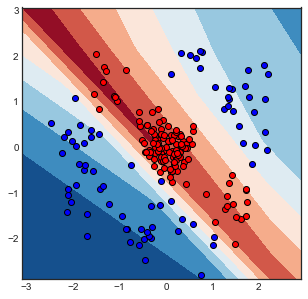

Epoch no. 96
accuracy: 0.8650
loss: 0.4511
Epoch no. 97
accuracy: 0.8650
loss: 0.4484
Epoch no. 98
accuracy: 0.8700
loss: 0.4457
Epoch no. 99
accuracy: 0.8700
loss: 0.4430
Epoch no. 100
accuracy: 0.8700
loss: 0.4404


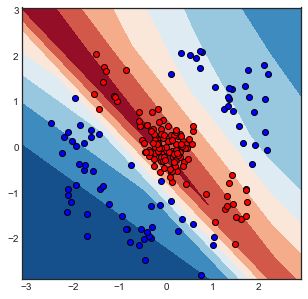

Epoch no. 101
accuracy: 0.8700
loss: 0.4378
Epoch no. 102
accuracy: 0.8700
loss: 0.4351
Epoch no. 103
accuracy: 0.8700
loss: 0.4326
Epoch no. 104
accuracy: 0.8750
loss: 0.4300
Epoch no. 105
accuracy: 0.8750
loss: 0.4275


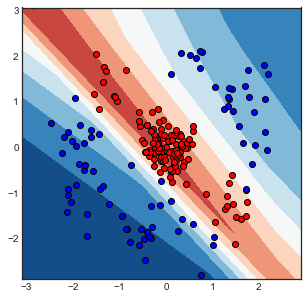

Epoch no. 106
accuracy: 0.8750
loss: 0.4250
Epoch no. 107
accuracy: 0.8750
loss: 0.4226
Epoch no. 108
accuracy: 0.8750
loss: 0.4202
Epoch no. 109
accuracy: 0.8800
loss: 0.4178
Epoch no. 110
accuracy: 0.8800
loss: 0.4155


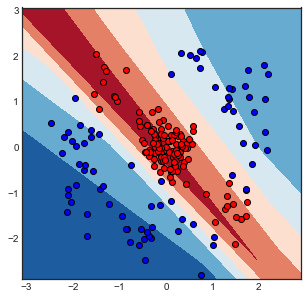

Epoch no. 111
accuracy: 0.8800
loss: 0.4132
Epoch no. 112
accuracy: 0.8800
loss: 0.4109
Epoch no. 113
accuracy: 0.8750
loss: 0.4086
Epoch no. 114
accuracy: 0.8750
loss: 0.4064
Epoch no. 115
accuracy: 0.8750
loss: 0.4042


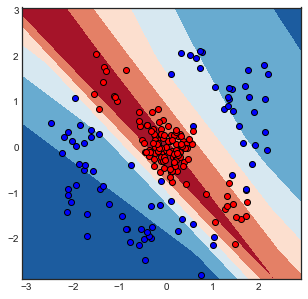

Epoch no. 116
accuracy: 0.8750
loss: 0.4020
Epoch no. 117
accuracy: 0.8750
loss: 0.3998
Epoch no. 118
accuracy: 0.8750
loss: 0.3978
Epoch no. 119
accuracy: 0.8750
loss: 0.3958
Epoch no. 120
accuracy: 0.8750
loss: 0.3938


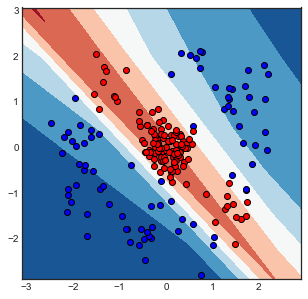

Epoch no. 121
accuracy: 0.8750
loss: 0.3919
Epoch no. 122
accuracy: 0.8750
loss: 0.3900
Epoch no. 123
accuracy: 0.8750
loss: 0.3882
Epoch no. 124
accuracy: 0.8750
loss: 0.3864
Epoch no. 125
accuracy: 0.8750
loss: 0.3846


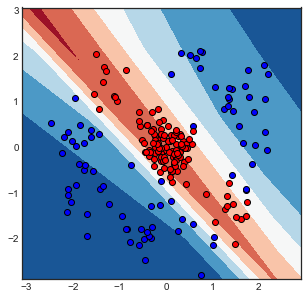

Epoch no. 126
accuracy: 0.8750
loss: 0.3829
Epoch no. 127
accuracy: 0.8750
loss: 0.3812
Epoch no. 128
accuracy: 0.8750
loss: 0.3796
Epoch no. 129
accuracy: 0.8750
loss: 0.3781
Epoch no. 130
accuracy: 0.8750
loss: 0.3766


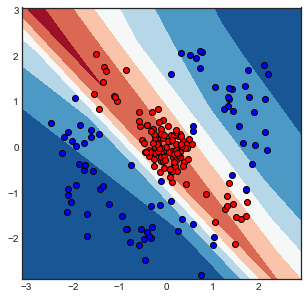

Epoch no. 131
accuracy: 0.8700
loss: 0.3751
Epoch no. 132
accuracy: 0.8700
loss: 0.3736
Epoch no. 133
accuracy: 0.8750
loss: 0.3723
Epoch no. 134
accuracy: 0.8750
loss: 0.3709
Epoch no. 135
accuracy: 0.8750
loss: 0.3696


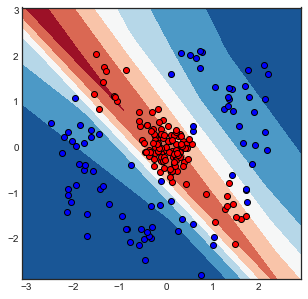

Epoch no. 136
accuracy: 0.8750
loss: 0.3684
Epoch no. 137
accuracy: 0.8750
loss: 0.3671
Epoch no. 138
accuracy: 0.8750
loss: 0.3659
Epoch no. 139
accuracy: 0.8750
loss: 0.3648
Epoch no. 140
accuracy: 0.8750
loss: 0.3637


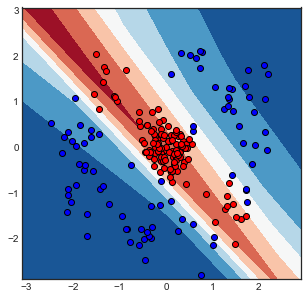

Epoch no. 141
accuracy: 0.8750
loss: 0.3626
Epoch no. 142
accuracy: 0.8750
loss: 0.3616
Epoch no. 143
accuracy: 0.8750
loss: 0.3606
Epoch no. 144
accuracy: 0.8750
loss: 0.3596
Epoch no. 145
accuracy: 0.8750
loss: 0.3587


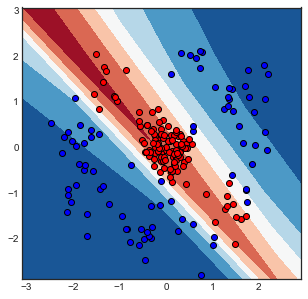

Epoch no. 146
accuracy: 0.8750
loss: 0.3578
Epoch no. 147
accuracy: 0.8750
loss: 0.3569
Epoch no. 148
accuracy: 0.8750
loss: 0.3560
Epoch no. 149
accuracy: 0.8750
loss: 0.3552
Epoch no. 150
accuracy: 0.8750
loss: 0.3544


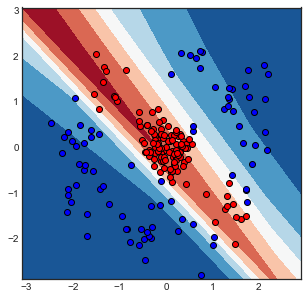

Epoch no. 151
accuracy: 0.8750
loss: 0.3536
Epoch no. 152
accuracy: 0.8750
loss: 0.3529
Epoch no. 153
accuracy: 0.8750
loss: 0.3521
Epoch no. 154
accuracy: 0.8750
loss: 0.3514
Epoch no. 155
accuracy: 0.8800
loss: 0.3508


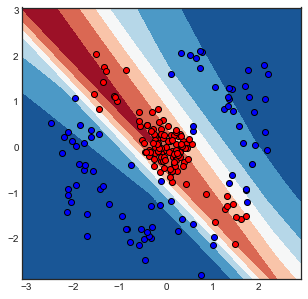

Epoch no. 156
accuracy: 0.8800
loss: 0.3501
Epoch no. 157
accuracy: 0.8800
loss: 0.3494
Epoch no. 158
accuracy: 0.8800
loss: 0.3488
Epoch no. 159
accuracy: 0.8800
loss: 0.3482
Epoch no. 160
accuracy: 0.8800
loss: 0.3476


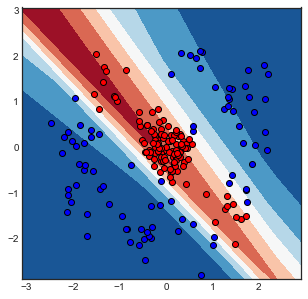

Epoch no. 161
accuracy: 0.8800
loss: 0.3470
Epoch no. 162
accuracy: 0.8800
loss: 0.3465
Epoch no. 163
accuracy: 0.8800
loss: 0.3459
Epoch no. 164
accuracy: 0.8800
loss: 0.3454
Epoch no. 165
accuracy: 0.8800
loss: 0.3449


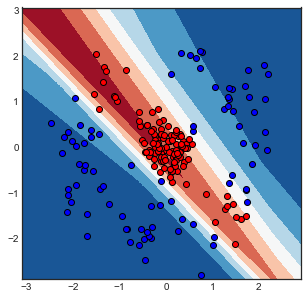

Epoch no. 166
accuracy: 0.8800
loss: 0.3445
Epoch no. 167
accuracy: 0.8800
loss: 0.3440
Epoch no. 168
accuracy: 0.8800
loss: 0.3435
Epoch no. 169
accuracy: 0.8800
loss: 0.3431
Epoch no. 170
accuracy: 0.8800
loss: 0.3427


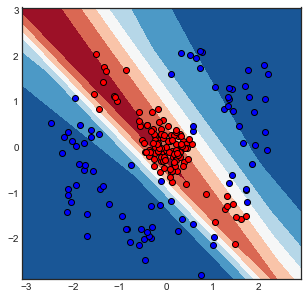

Epoch no. 171
accuracy: 0.8800
loss: 0.3422
Epoch no. 172
accuracy: 0.8800
loss: 0.3418
Epoch no. 173
accuracy: 0.8800
loss: 0.3415
Epoch no. 174
accuracy: 0.8800
loss: 0.3411
Epoch no. 175
accuracy: 0.8800
loss: 0.3407


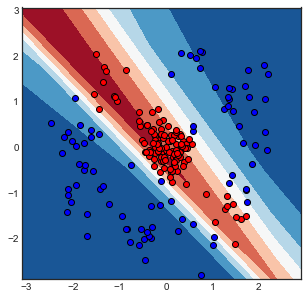

Epoch no. 176
accuracy: 0.8800
loss: 0.3403
Epoch no. 177
accuracy: 0.8800
loss: 0.3400
Epoch no. 178
accuracy: 0.8800
loss: 0.3397
Epoch no. 179
accuracy: 0.8800
loss: 0.3393
Epoch no. 180
accuracy: 0.8800
loss: 0.3390


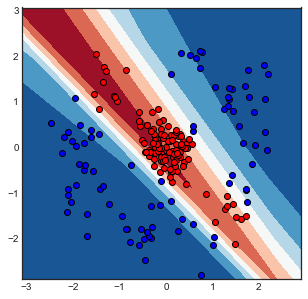

Epoch no. 181
accuracy: 0.8800
loss: 0.3387
Epoch no. 182
accuracy: 0.8800
loss: 0.3384
Epoch no. 183
accuracy: 0.8800
loss: 0.3381
Epoch no. 184
accuracy: 0.8800
loss: 0.3378
Epoch no. 185
accuracy: 0.8800
loss: 0.3375


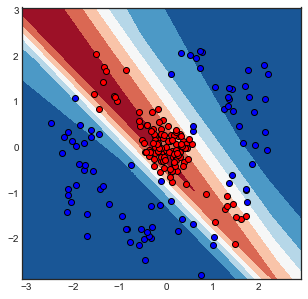

Epoch no. 186
accuracy: 0.8800
loss: 0.3373
Epoch no. 187
accuracy: 0.8800
loss: 0.3370
Epoch no. 188
accuracy: 0.8800
loss: 0.3367
Epoch no. 189
accuracy: 0.8800
loss: 0.3365
Epoch no. 190
accuracy: 0.8800
loss: 0.3363


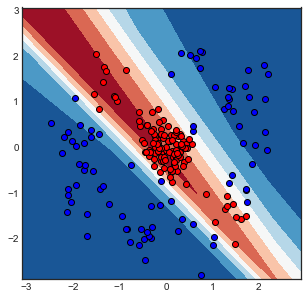

Epoch no. 191
accuracy: 0.8800
loss: 0.3360
Epoch no. 192
accuracy: 0.8800
loss: 0.3358
Epoch no. 193
accuracy: 0.8800
loss: 0.3356
Epoch no. 194
accuracy: 0.8800
loss: 0.3353
Epoch no. 195
accuracy: 0.8800
loss: 0.3351


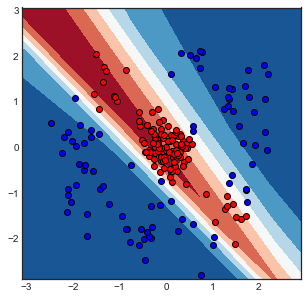

Epoch no. 196
accuracy: 0.8800
loss: 0.3349
Epoch no. 197
accuracy: 0.8800
loss: 0.3347
Epoch no. 198
accuracy: 0.8800
loss: 0.3345
Epoch no. 199
accuracy: 0.8800
loss: 0.3343
Epoch no. 200
accuracy: 0.8800
loss: 0.3341


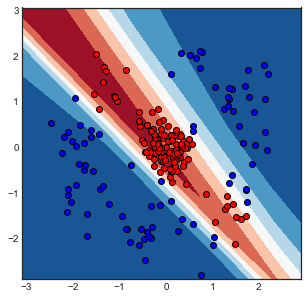

Epoch no. 201
accuracy: 0.8800
loss: 0.3340
Epoch no. 202
accuracy: 0.8800
loss: 0.3338
Epoch no. 203
accuracy: 0.8800
loss: 0.3336
Epoch no. 204
accuracy: 0.8800
loss: 0.3334
Epoch no. 205
accuracy: 0.8800
loss: 0.3333


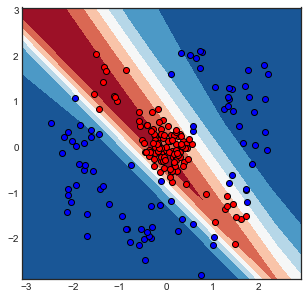

Epoch no. 206
accuracy: 0.8800
loss: 0.3331
Epoch no. 207
accuracy: 0.8800
loss: 0.3329
Epoch no. 208
accuracy: 0.8800
loss: 0.3328
Epoch no. 209
accuracy: 0.8800
loss: 0.3326
Epoch no. 210
accuracy: 0.8800
loss: 0.3325


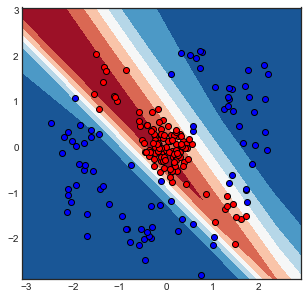

Epoch no. 211
accuracy: 0.8800
loss: 0.3323
Epoch no. 212
accuracy: 0.8800
loss: 0.3322
Epoch no. 213
accuracy: 0.8800
loss: 0.3321
Epoch no. 214
accuracy: 0.8800
loss: 0.3319
Epoch no. 215
accuracy: 0.8800
loss: 0.3318


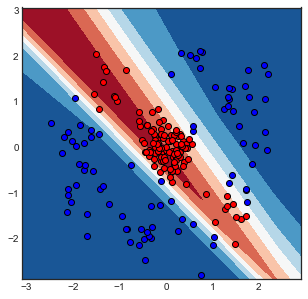

Epoch no. 216
accuracy: 0.8800
loss: 0.3317
Epoch no. 217
accuracy: 0.8800
loss: 0.3315
Epoch no. 218
accuracy: 0.8800
loss: 0.3314
Epoch no. 219
accuracy: 0.8800
loss: 0.3313
Epoch no. 220
accuracy: 0.8800
loss: 0.3312


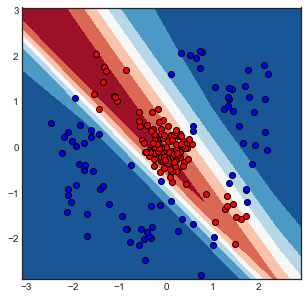

Epoch no. 221
accuracy: 0.8800
loss: 0.3310
Epoch no. 222
accuracy: 0.8800
loss: 0.3309
Epoch no. 223
accuracy: 0.8800
loss: 0.3308
Epoch no. 224
accuracy: 0.8800
loss: 0.3307
Epoch no. 225
accuracy: 0.8800
loss: 0.3306


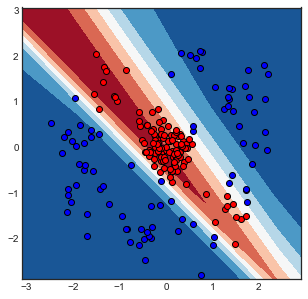

Epoch no. 226
accuracy: 0.8800
loss: 0.3305
Epoch no. 227
accuracy: 0.8800
loss: 0.3304
Epoch no. 228
accuracy: 0.8800
loss: 0.3303
Epoch no. 229
accuracy: 0.8800
loss: 0.3302
Epoch no. 230
accuracy: 0.8800
loss: 0.3301


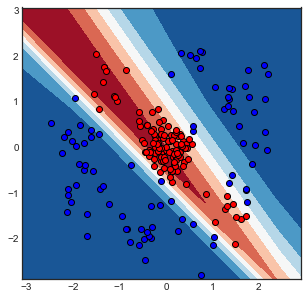

Epoch no. 231
accuracy: 0.8800
loss: 0.3300
Epoch no. 232
accuracy: 0.8800
loss: 0.3299
Epoch no. 233
accuracy: 0.8800
loss: 0.3298
Epoch no. 234
accuracy: 0.8800
loss: 0.3298
Epoch no. 235
accuracy: 0.8800
loss: 0.3297


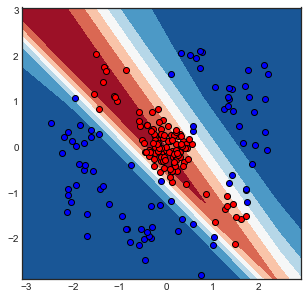

Epoch no. 236
accuracy: 0.8800
loss: 0.3296
Epoch no. 237
accuracy: 0.8800
loss: 0.3295
Epoch no. 238
accuracy: 0.8800
loss: 0.3294
Epoch no. 239
accuracy: 0.8800
loss: 0.3294
Epoch no. 240
accuracy: 0.8800
loss: 0.3293


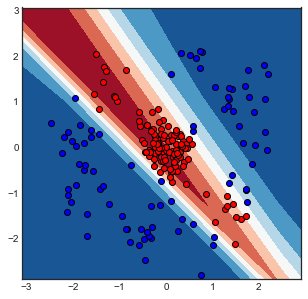

Epoch no. 241
accuracy: 0.8800
loss: 0.3292
Epoch no. 242
accuracy: 0.8800
loss: 0.3291
Epoch no. 243
accuracy: 0.8800
loss: 0.3291
Epoch no. 244
accuracy: 0.8800
loss: 0.3290
Epoch no. 245
accuracy: 0.8800
loss: 0.3289


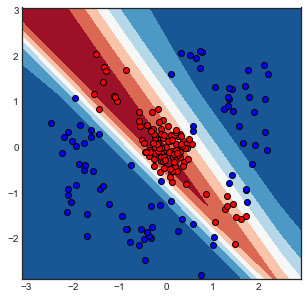

Epoch no. 246
accuracy: 0.8800
loss: 0.3288
Epoch no. 247
accuracy: 0.8800
loss: 0.3288
Epoch no. 248
accuracy: 0.8800
loss: 0.3287
Epoch no. 249
accuracy: 0.8800
loss: 0.3286
Epoch no. 250
accuracy: 0.8800
loss: 0.3286


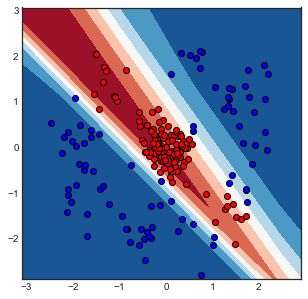

Epoch no. 251
accuracy: 0.8800
loss: 0.3285
Epoch no. 252
accuracy: 0.8800
loss: 0.3285
Epoch no. 253
accuracy: 0.8800
loss: 0.3284
Epoch no. 254
accuracy: 0.8800
loss: 0.3283
Epoch no. 255
accuracy: 0.8800
loss: 0.3283


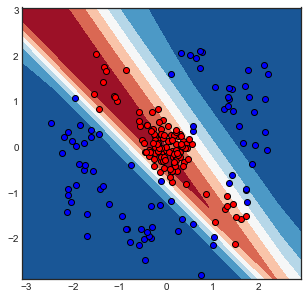

Epoch no. 256
accuracy: 0.8800
loss: 0.3282
Epoch no. 257
accuracy: 0.8800
loss: 0.3282
Epoch no. 258
accuracy: 0.8800
loss: 0.3281
Epoch no. 259
accuracy: 0.8800
loss: 0.3281
Epoch no. 260
accuracy: 0.8800
loss: 0.3280


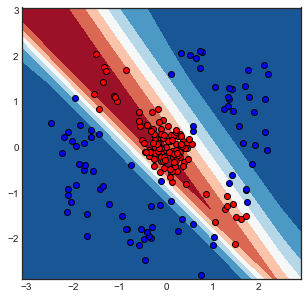

Epoch no. 261
accuracy: 0.8800
loss: 0.3280
Epoch no. 262
accuracy: 0.8800
loss: 0.3279
Epoch no. 263
accuracy: 0.8800
loss: 0.3278
Epoch no. 264
accuracy: 0.8800
loss: 0.3278
Epoch no. 265
accuracy: 0.8800
loss: 0.3277


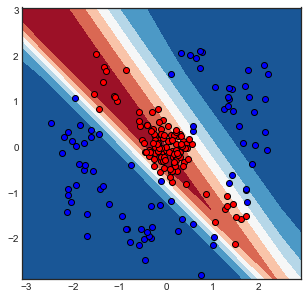

Epoch no. 266
accuracy: 0.8800
loss: 0.3277
Epoch no. 267
accuracy: 0.8800
loss: 0.3277
Epoch no. 268
accuracy: 0.8800
loss: 0.3276
Epoch no. 269
accuracy: 0.8800
loss: 0.3276
Epoch no. 270
accuracy: 0.8800
loss: 0.3275


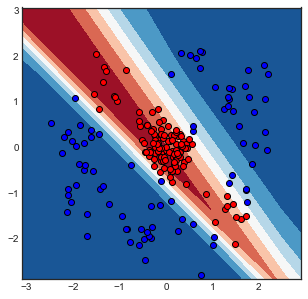

Epoch no. 271
accuracy: 0.8800
loss: 0.3275
Epoch no. 272
accuracy: 0.8800
loss: 0.3274
Epoch no. 273
accuracy: 0.8800
loss: 0.3274
Epoch no. 274
accuracy: 0.8800
loss: 0.3273
Epoch no. 275
accuracy: 0.8800
loss: 0.3273


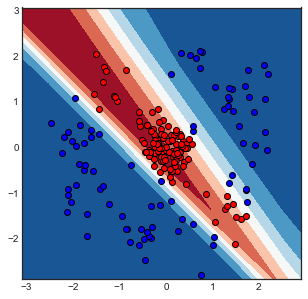

Epoch no. 276
accuracy: 0.8800
loss: 0.3272
Epoch no. 277
accuracy: 0.8800
loss: 0.3272
Epoch no. 278
accuracy: 0.8800
loss: 0.3272
Epoch no. 279
accuracy: 0.8800
loss: 0.3271
Epoch no. 280
accuracy: 0.8800
loss: 0.3271


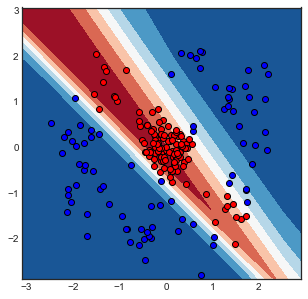

Epoch no. 281
accuracy: 0.8800
loss: 0.3270
Epoch no. 282
accuracy: 0.8800
loss: 0.3270
Epoch no. 283
accuracy: 0.8800
loss: 0.3270
Epoch no. 284
accuracy: 0.8800
loss: 0.3269
Epoch no. 285
accuracy: 0.8800
loss: 0.3269


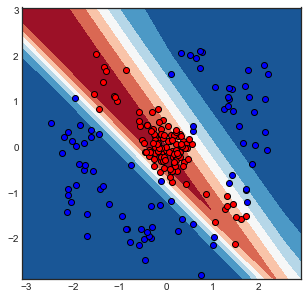

Epoch no. 286
accuracy: 0.8800
loss: 0.3268
Epoch no. 287
accuracy: 0.8800
loss: 0.3268
Epoch no. 288
accuracy: 0.8800
loss: 0.3268
Epoch no. 289
accuracy: 0.8800
loss: 0.3267
Epoch no. 290
accuracy: 0.8800
loss: 0.3267


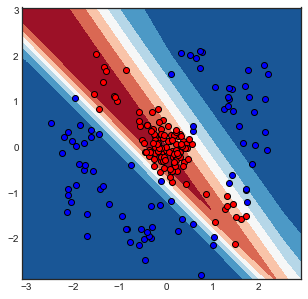

Epoch no. 291
accuracy: 0.8800
loss: 0.3267
Epoch no. 292
accuracy: 0.8800
loss: 0.3266
Epoch no. 293
accuracy: 0.8800
loss: 0.3266
Epoch no. 294
accuracy: 0.8800
loss: 0.3265
Epoch no. 295
accuracy: 0.8800
loss: 0.3265


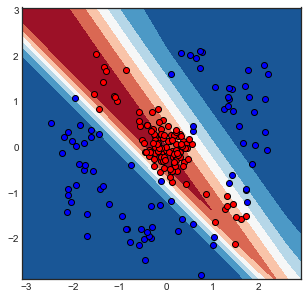

Epoch no. 296
accuracy: 0.8800
loss: 0.3265
Epoch no. 297
accuracy: 0.8800
loss: 0.3264
Epoch no. 298
accuracy: 0.8800
loss: 0.3264
Epoch no. 299
accuracy: 0.8800
loss: 0.3264


In [20]:
net2 = Net(layers=[Linear(2, 4), ReLU(), Linear(4, 4), ReLU(), Linear(4, 2) ],
          loss=CrossEntropyLoss())

n_epochs = 300

loss_val, acc_val = [], []

for epoch_idx in range(n_epochs):
    print("Epoch no. %d" % epoch_idx)
    out = net2(X)
    # prediction accuracy
    pred = np.argmax(out, axis=1)
    print("accuracy: %1.4f" % (1 - np.abs(pred - Y_labels).sum()/200))
    loss = net2.loss(out, Y_labels)
    print('loss: %1.4f' % loss)
    grad = net2.backward()
    net2.update_weights(lr=0.1)
    
    acc = 1 - np.abs(pred - Y_labels).sum()/200
    loss_val.append(loss)
    acc_val.append(acc)
    
    if epoch_idx % 5 == 0:
        plot_classifier(net2, X, x_meshgrid, y_meshgrid, X_grid)

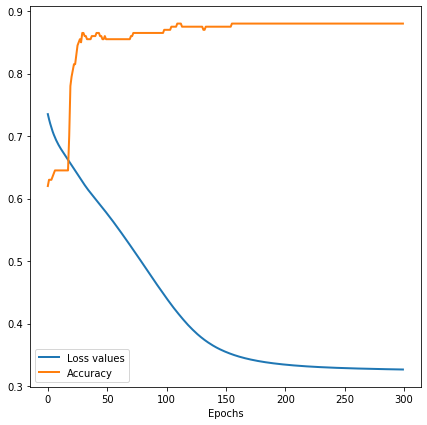

In [21]:
plt.figure(figsize=(7, 7))
plt.plot( np.arange(0, n_epochs, 1) ,  np.array(loss_val), linewidth=2, label='Loss values' )
plt.plot( np.arange(0, n_epochs, 1) ,  np.array(acc_val), linewidth=2, label='Accuracy' )
plt.xlabel('Epochs')
plt.legend()

In [22]:
out = net2(X_test)
pred = np.argmax(out, axis=1)

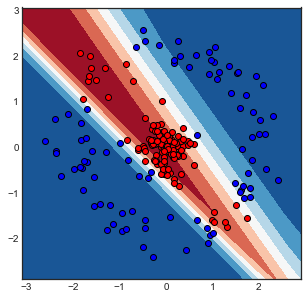

accuracy: 0.8800


In [23]:
plot_classifier(net2, X_test, x_meshgrid, y_meshgrid, X_grid)
print("accuracy: %1.4f" % (1 - np.abs(pred - Y_labels_test).sum()/200))